In [1]:
pip install rarfile

In [2]:
import rarfile
import os

# Define the path to the uploaded RAR file
rar_file_path = '/content/mini_dataset.rar'

# Define the directory where you want to extract the files
extract_dir = '/content/data/'

# Create the directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the RAR file
with rarfile.RarFile(rar_file_path) as rar_ref:
    rar_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Files extracted to: /content/data/


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import re
import nltk
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW

In [4]:
# read the data
data = pd.read_csv('/content/data/mini_dataset.csv')
data.head()

,text,generated
0,I believe that online classes and video confe...,1.0
1,Hhe benefits of having a positive attitude ar...,1.0
2,"As an eighth grade student, I believe that pro...",1.0
3,Title: The Facial Action Coding System: Decodi...,1.0
4,A positive attitude is a powerful tool that c...,1.0


In [5]:
# Step 2: Split into X and y
X = data['text'].values
y = data['generated'].values

In [6]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
def encode_data(texts, tokenizer, max_length=128):
    # Ensure texts is a list of strings (convert to list if it's not)
    if isinstance(texts, str):
        texts = [texts]  # Make it a list
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()  # Convert NumPy array to list if necessary
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt',
        is_split_into_words=False  # Ensure it's not split into words for regular sentences
    )

# Correct encoding of the training and validation data
train_encodings = encode_data(X_train, tokenizer)
val_encodings = encode_data(X_val, tokenizer)

In [8]:
# Convert to torch datasets
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(y_train, dtype=torch.long)  # Ensure labels are integers (long type)
)
val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(y_val, dtype=torch.long)  # Ensure labels are integers (long type)
)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Phase
model.train()
for epoch in range(3):  # 3 epochs
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # This already calculates the loss using integer labels

        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.22073654966287665
Epoch 2, Loss: 0.046638217031794334
Epoch 3, Loss: 0.011447669664819788


Accuracy: 0.945750452079566
Precision: 0.9064516129032258
Recall: 0.9964539007092199
F1-Score: 0.9493243243243243

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       271
           1       0.91      1.00      0.95       282

    accuracy                           0.95       553
   macro avg       0.95      0.94      0.95       553
weighted avg       0.95      0.95      0.95       553


Confusion Matrix:
[[242  29]
 [  1 281]]


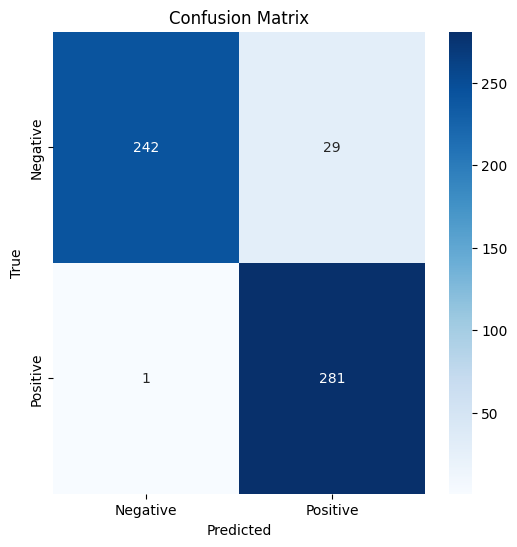


Model saved to './saved_bert_model'


In [9]:
# Evaluation Phase
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to predictions
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(true_labels, predictions)
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save the model
model.save_pretrained('./saved_bert_model')
tokenizer.save_pretrained('./saved_bert_model')
print("\nModel saved to './saved_bert_model'")